<a href="https://colab.research.google.com/github/KoraySali/Dissertation_Archive/blob/main/model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Image Detection Dissertation**

This file will include a number of important architectures, code and technologies. A Convolutional Neural Network (CNN) model will be used for the image detection of SMOKE, NO SMOKE, FIRE, NO FIRE classification.

A chosen methodology will be followed in order to prevent confusion when writting and coding this dissertation. Various evaluation metrics will be used to evaluate the outcome of the image detection model along with a number of visualisations for readability.

For copy/version issues a Github repository has been set up in order to retain versions and prevent loss of work.

The runtime of this file will be GPU as a CPU runtime took a lot longer to perform/execute our code.

In [1]:
!git clone https://github.com/KoraySali/Dissertation_Archive.git

Cloning into 'Dissertation_Archive'...
remote: Enumerating objects: 11969, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 11969 (delta 36), reused 147 (delta 35), pack-reused 11820
Receiving objects: 100% (11969/11969), 50.12 MiB | 36.89 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
!pip install wandb

In [21]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
wandb.init(project='Visualisations 1')

wandb: Currently logged in as: s5216739 (s5216739-koray). Use `wandb login --relogin` to force relogin


## Linking our Google Drive to our ipynb file

An important step in this file is to link it to our Google Drive allowing for usability of the drive folder for uploading and downloading various files/folders.

## Importing our modules and libraries



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from skimage import io, transform
import time
import tensorflow_hub as hub

%matplotlib inline

## Select images in the folder

In [3]:
def select_images_in_folder(preprocessed_folders):
    all_images = []

    for image_file in os.listdir(preprocessed_folders):
        read_image_path = os.path.join(preprocessed_folders, image_file)

        if os.path.isfile(read_image_path) is not None:
            single_image = mpimg.imread(read_image_path)
            all_images.append(single_image)
        else:
          print("Cannot return any images from " + preprocessed_folders)

    return all_images

In [4]:
preprocessed_train_fire_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_fire")
preprocessed_train_smoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_smoke")
preprocessed_train_nofire_nosmoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_nofire_nosmoke")

In [5]:
len(preprocessed_train_fire_images)

4000

# Label Encoding 

In [6]:
from sklearn.preprocessing import LabelEncoder

label_names = ['Fire', 'Smoke', 'No Fire or Smoke']
Label_encoder = LabelEncoder()
Label_encoder.fit(label_names)
train_fire_labels = Label_encoder.transform(['Fire'] * len(preprocessed_train_fire_images))
train_smoke_labels =  Label_encoder.transform(['Smoke'] * len(preprocessed_train_smoke_images))
train_nofire_nosmoke_labels = Label_encoder.transform(['No Fire or Smoke'] * len(preprocessed_train_nofire_nosmoke_images))

In [7]:
type(label_names)

list

# One-hot encoding labels

In [ ]:
from keras.utils import to_categorical

train_fire_labels = [0 for i in range(len(preprocessed_train_fire_images))]
train_smoke_labels = [1 for i in range(len(preprocessed_train_smoke_images))]
train_nofire_nosmoke_labels = [2 for i in range(len(preprocessed_train_nofire_nosmoke_images))]

# One-hot encoding the labels using keras library
train_fire_labels = tf.keras.utils.to_categorical(train_fire_labels, num_classes=3)
train_smoke_labels =  tf.keras.utils.to_categorical(train_smoke_labels, num_classes=3)
train_nofire_nosmoke_labels =  tf.keras.utils.to_categorical(train_nofire_nosmoke_labels, num_classes=3)

Checks done below to ensure the correct coding of the labels.

In [8]:
train_fire_labels

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
preprocessed_train_fire_images[0].shape

(128, 128, 3)

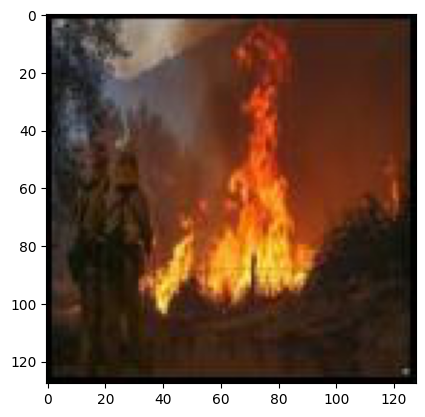

In [11]:
for single_image in preprocessed_train_fire_images[:10]:
  plt.imshow(single_image)

## Training and testing split for our model to use

This is slightly redundant as we do this in our Google Colaboratory file so when running this code skip this as there becomes no need.

In [8]:
# Combining the preprocessed images and their labels

X_train = np.concatenate([preprocessed_train_fire_images, preprocessed_train_smoke_images, preprocessed_train_nofire_nosmoke_images])
y_train = np.concatenate([train_fire_labels, train_smoke_labels, train_nofire_nosmoke_labels])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


In [12]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [13]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


# Data Augmentation

## Model Creation

Below is the first base model.

In [ ]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [ ]:
base_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_base = base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
116/300 [==========>...................] - ETA: 3s - loss: 0.7311 - accuracy: 0.9332

KeyboardInterrupt: ignored

# Complete Model

In [ ]:
wandb.init(project='Visualisations 1', entity='s5216739', name='training_run')

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, # randomly rotate images up to 20 degrees
    zoom_range=0.1, # randomly zoom images by up to 10%
    width_shift_range=0.1, # randomly shift images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift images vertically by up to 10%
    shear_range=0.1, # randomly apply shearing transformations up to 10%
    horizontal_flip=True, # randomly flip images horizontally
    fill_mode='nearest' # fill in any empty pixels with the nearest value
)

In [10]:
complete_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [11]:
complete_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# wandb_callback = wandb.keras.WandbCallback()
history_complete = complete_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 30s 46ms/step - loss: 0.2586 - accuracy: 0.9009 - val_loss: 0.3359 - val_accuracy: 0.8788
Epoch 2/10
300/300 [==============================] - 14s 45ms/step - loss: 0.1697 - accuracy: 0.9361 - val_loss: 0.2065 - val_accuracy: 0.9221
Epoch 3/10
300/300 [==============================] - 14s 46ms/step - loss: 0.1332 - accuracy: 0.9504 - val_loss: 0.2880 - val_accuracy: 0.8879
Epoch 4/10
300/300 [==============================] - 13s 45ms/step - loss: 0.1091 - accuracy: 0.9615 - val_loss: 0.1322 - val_accuracy: 0.9533
Epoch 5/10
300/300 [==============================] - 14s 46ms/step - loss: 0.0891 - accuracy: 0.9681 - val_loss: 0.2092 - val_accuracy: 0.9287
Epoch 6/10
300/300 [==============================] - 16s 52ms/step - loss: 0.0750 - accuracy: 0.9747 - val_loss: 0.1832 - val_accuracy: 0.9408
Epoch 7/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0603 - accuracy: 0.9791 - val_loss: 0.3488 - val_accuracy:

In [23]:
wandb.log({'model_weights': complete_model.get_weights()})

wandb: WARNING Serializing object of type ndarray that is 147616 bytes
wandb: WARNING Serializing object of type ndarray that is 295072 bytes
wandb: WARNING Serializing object of type ndarray that is 589984 bytes
wandb: WARNING Serializing object of type ndarray that is 16777344 bytes


In [ ]:
# Define the hyperparameters to optimize
sweep_config = {
    "method": "random",
    "parameters": {
        "learning_rate": {"values": [0.01, 0.001, 0.0001]},
        "batch_size": {"values": [16, 32, 64]},
        "num_filters": {"values": [32, 64, 128]},
        "kernel_size": {"values": [3, 5]},
        "activation": {"values": ["relu", "tanh"]},
        "dropout_rate": {"values": [0.0, 0.25, 0.5]},
    },
}

# Initialize a sweep
sweep_id = wandb.sweep(sweep_config, project="CNN-TEST-MODEL", entity="s5216739")

def train():
    # Define the model architecture
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation, input_shape=[128,128,3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(filters=2*wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=2*wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=4*wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=4*wandb.config.num_filters, kernel_size=wandb.config.kernel_size, padding="same", activation=wandb.config.activation),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=wandb.config.activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=wandb.config.dropout_rate),
        tf.keras.layers.Dense(3, activation="softmax")
    ])
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])
    
    # Train the model
    wandb_callback = wandb.keras.WandbCallback()
    history = model.fit(X_train, y_train, epochs=10, batch_size=wandb.config.batch_size, validation_data=(X_test, y_test), callbacks=[wandb_callback])
    
    # Log the results to wandb
    wandb.log({"val_accuracy": history.history["val_accuracy"][-1]})
    
# Run the sweep
wandb.agent(sweep_id, function=train)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 441eag03 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 32
Exception in thread Thread-474:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_config.py", line 163, in __getattr__
    return self.__getitem__(key)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'num_filters'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "<ipython-input-38-c7a1a8f3ad3e>", line 20, in train
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_config.py", line 165, in __getattr__
    raise A

# Transfer-learning of pre-trained models

In [ ]:
# Load the pre-trained models imports
xception_import = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg_import = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_import = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
def pre_trained_model_learning(model):

  for freezing_layer in model.layers:
    freezing_layer.trainable = False
    
  custom_model_flatten = tf.keras.layers.Flatten()(model.output)
  custom_model_dense1 = tf.keras.layers.Dense(256, activation='relu')(custom_model_flatten)
  custom_model_dense2 = tf.keras.layers.Dense(128, activation='relu')(custom_model_dense1)
  custom_model_output = tf.keras.layers.Dense(3, activation='softmax')(custom_model_dense2)

  model = tf.keras.models.Model(inputs=model.input, outputs=custom_model_output)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
  history_model = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

  return history_model, model

In [ ]:
vgg_model = pre_trained_model_learning(vgg_import)

Epoch 1/10
300/300 [==============================] - 19s 58ms/step - loss: 0.4526 - accuracy: 0.9256 - val_loss: 0.1263 - val_accuracy: 0.9567
Epoch 2/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0620 - accuracy: 0.9801 - val_loss: 0.1442 - val_accuracy: 0.9596
Epoch 3/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0334 - accuracy: 0.9910 - val_loss: 0.1635 - val_accuracy: 0.9621
Epoch 4/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0295 - accuracy: 0.9924 - val_loss: 0.1692 - val_accuracy: 0.9583
Epoch 5/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.2443 - val_accuracy: 0.9521
Epoch 6/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0519 - accuracy: 0.9868 - val_loss: 0.3627 - val_accuracy: 0.9442
Epoch 7/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0340 - accuracy: 0.9924 - val_loss: 0.2433 - val_accuracy:

In [ ]:
xception_model = pre_trained_model_learning(xception_import)

Epoch 1/10
300/300 [==============================] - 23s 61ms/step - loss: 6.0717 - accuracy: 0.7856 - val_loss: 0.8778 - val_accuracy: 0.8562
Epoch 2/10
300/300 [==============================] - 17s 56ms/step - loss: 0.5670 - accuracy: 0.8755 - val_loss: 0.9317 - val_accuracy: 0.8229
Epoch 3/10
300/300 [==============================] - 19s 64ms/step - loss: 0.4019 - accuracy: 0.8916 - val_loss: 0.3773 - val_accuracy: 0.8821
Epoch 4/10
300/300 [==============================] - 19s 63ms/step - loss: 0.3230 - accuracy: 0.9124 - val_loss: 0.4038 - val_accuracy: 0.8858
Epoch 5/10
300/300 [==============================] - 18s 61ms/step - loss: 0.2880 - accuracy: 0.9101 - val_loss: 0.5341 - val_accuracy: 0.8625
Epoch 6/10
300/300 [==============================] - 18s 60ms/step - loss: 0.2711 - accuracy: 0.9155 - val_loss: 0.4114 - val_accuracy: 0.8562
Epoch 7/10
300/300 [==============================] - 16s 53ms/step - loss: 0.2164 - accuracy: 0.9276 - val_loss: 0.3547 - val_accuracy:

In [ ]:
resnet_model = pre_trained_model_learning(resnet_import)

Epoch 1/10
300/300 [==============================] - 45s 112ms/step - loss: 0.3141 - accuracy: 0.9339 - val_loss: 0.1231 - val_accuracy: 0.9621
Epoch 2/10
300/300 [==============================] - 34s 114ms/step - loss: 0.0642 - accuracy: 0.9789 - val_loss: 0.1585 - val_accuracy: 0.9592
Epoch 3/10
300/300 [==============================] - 35s 118ms/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.1489 - val_accuracy: 0.9633
Epoch 4/10
300/300 [==============================] - 30s 100ms/step - loss: 0.0202 - accuracy: 0.9930 - val_loss: 0.1524 - val_accuracy: 0.9683
Epoch 5/10
300/300 [==============================] - 35s 115ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.1492 - val_accuracy: 0.9675
Epoch 6/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0407 - accuracy: 0.9899 - val_loss: 0.2819 - val_accuracy: 0.9533
Epoch 7/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0958 - accuracy: 0.9845 - val_loss: 0.2556 - val_ac

## Model Performance Analysis

In [14]:
test_loss, test_accuracy = complete_model.evaluate(X_test.reshape(-1,128,128,3), y_test, verbose=2)
print('Accuracy on test dataset:', test_accuracy)

75/75 - 1s - loss: 0.1399 - accuracy: 0.9575 - 1s/epoch - 14ms/step
Accuracy on test dataset: 0.9574999809265137


In [15]:
class_names = ['Fire', 'Smoke', 'No Fire or Smoke']

In [16]:
predicted_classes  = np.argmax(complete_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 2s 14ms/step


In [17]:
# Use this for the Label Encoder

correct=np.nonzero(predicted_classes==y_true)[0]
correct.shape[0]
incorrect=np.nonzero(predicted_classes!=y_true)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 2298
Incorrect predicted classes: 102


In [18]:
# Use this for one hot encoding

y_true = np.argmax(y_test, axis=-1)
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

print("Correctly predicted classes:",correct.shape[0])
print("Incorrectly predicted classes:",incorrect.shape[0])

Correctly predicted classes: 765
Incorrectly predicted classes: 1635


## Showing the plain correctly and incorrectly predicted imagery

In [19]:
## Plotting the train and test imagery
def plot_plain_images(data_index):
    f, ax = plt.subplots(3, 3, figsize=(10,10))

    for i, indx in enumerate(data_index[:9]):
        predicted_class = class_names[predicted_classes[indx]]
        true_class = class_names[y_true[indx]]
        ax[i//3, i%3].imshow(X_test[indx].reshape(128, 128, 3), cmap='gray')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title("True:{}  Pred:{}".format(true_class, predicted_class))

    f.tight_layout()
    plt.show()

TypeError: ignored

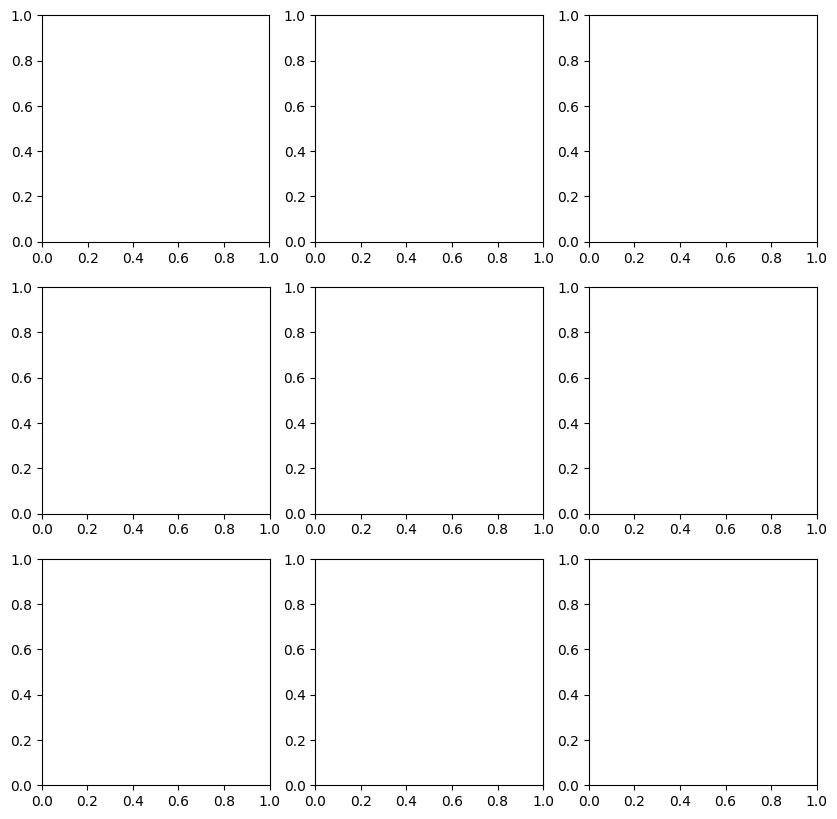

In [72]:
plot_plain_images(correct[:10])

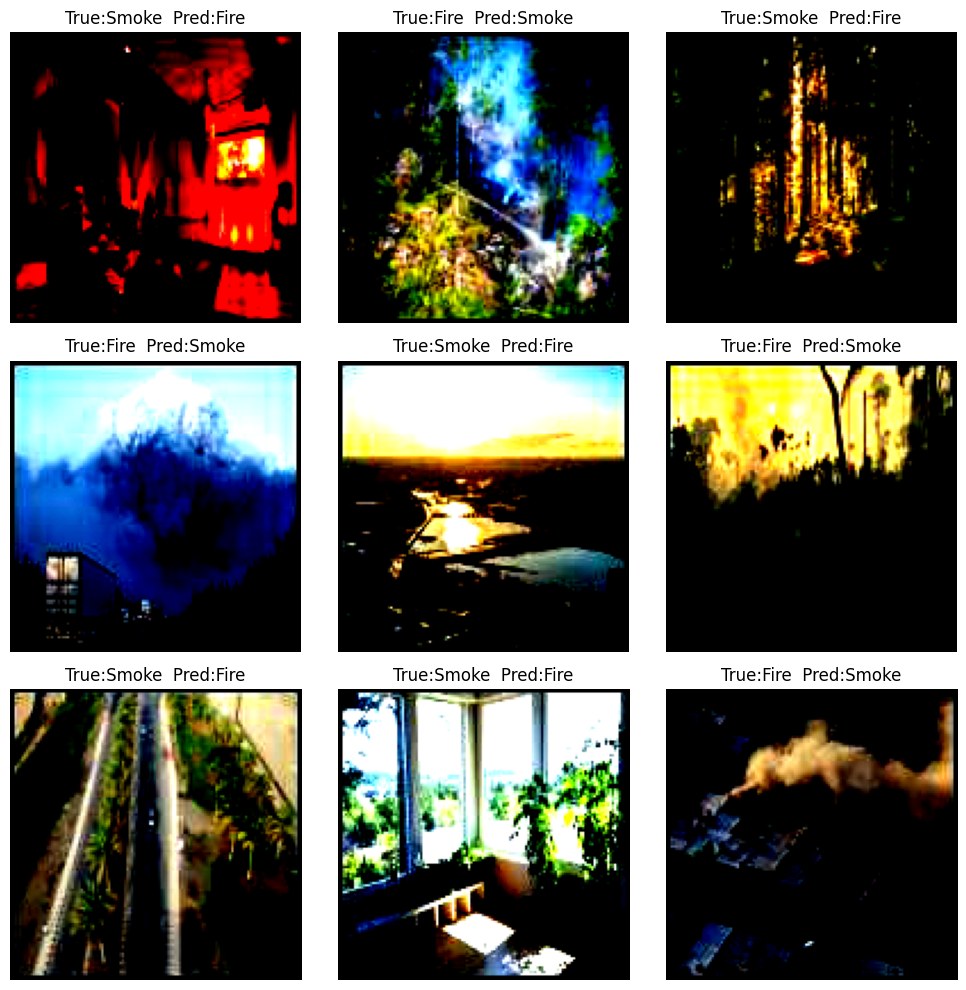

In [54]:
plot_plain_images(incorrect[:10])

**Save the h5 model file**

In [ ]:
tf.keras.models.save_model(complete_model, 'models/complete_cnn.h5')

In [ ]:
!git status

In [ ]:
!git add .

In [ ]:
!git commit -m "New model added"

In [ ]:
!git push

# Visualisations

In [55]:
y_pred = complete_model.predict(X_test[:10])
wandb.log({'predictions': wandb.Histogram(np.argmax(y_pred, axis=1))})

1/1 [==============================] - 1s 559ms/step


75/75 [==============================] - 1s 14ms/step


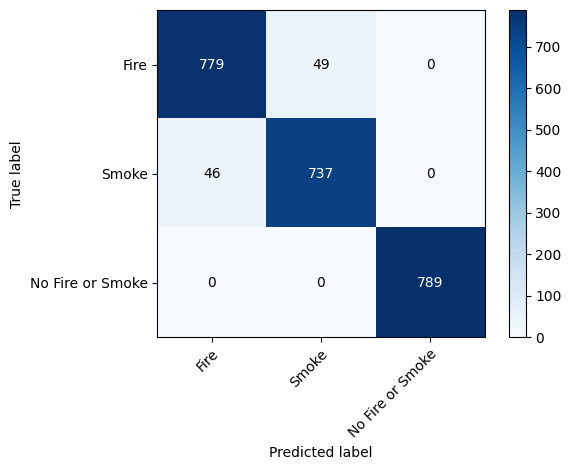

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = complete_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=label_names, yticklabels=label_names,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
wandb.log({'confusion_matrix': wandb.Image(fig)})

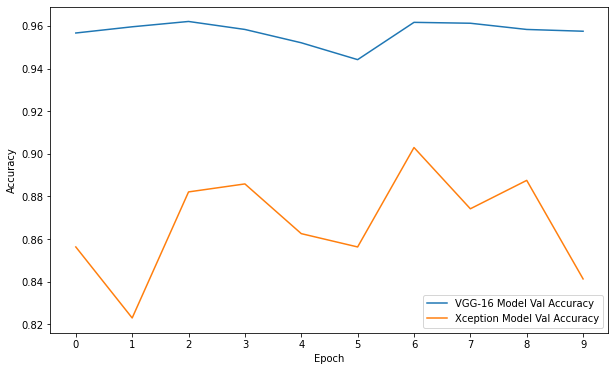

In [ ]:
plt.figure(figsize=(10, 6))

#plt.plot(history_base.history['val_accuracy'], label='Base Model Val Accuracy')
#plt.plot(history_complete.history['val_accuracy'], label='Complete Model Val Accuracy')
plt.plot(vgg_model.history['val_accuracy'], label='VGG-16 Model Val Accuracy')
plt.plot(xception_model.history['val_accuracy'], label='Xception Model Val Accuracy')
#plt.plot(resnet_model.history['val_accuracy'], label='ResNet152 Model Val Accuracy')

plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

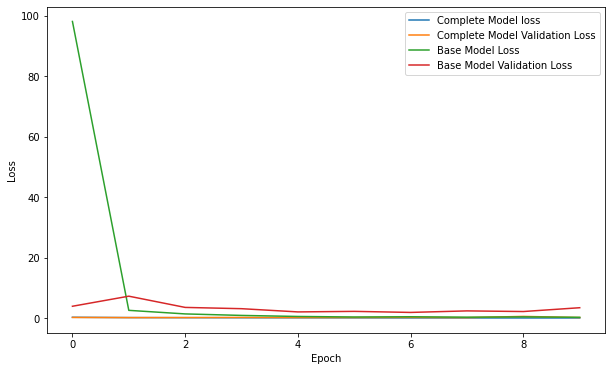

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history_complete.history['loss'], label='Complete Model loss')
plt.plot(history_complete.history['val_loss'], label='Complete Model Validation Loss')
plt.plot(history_base.history['loss'], label='Base Model Loss')
plt.plot(history_base.history['val_loss'], label='Base Model Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

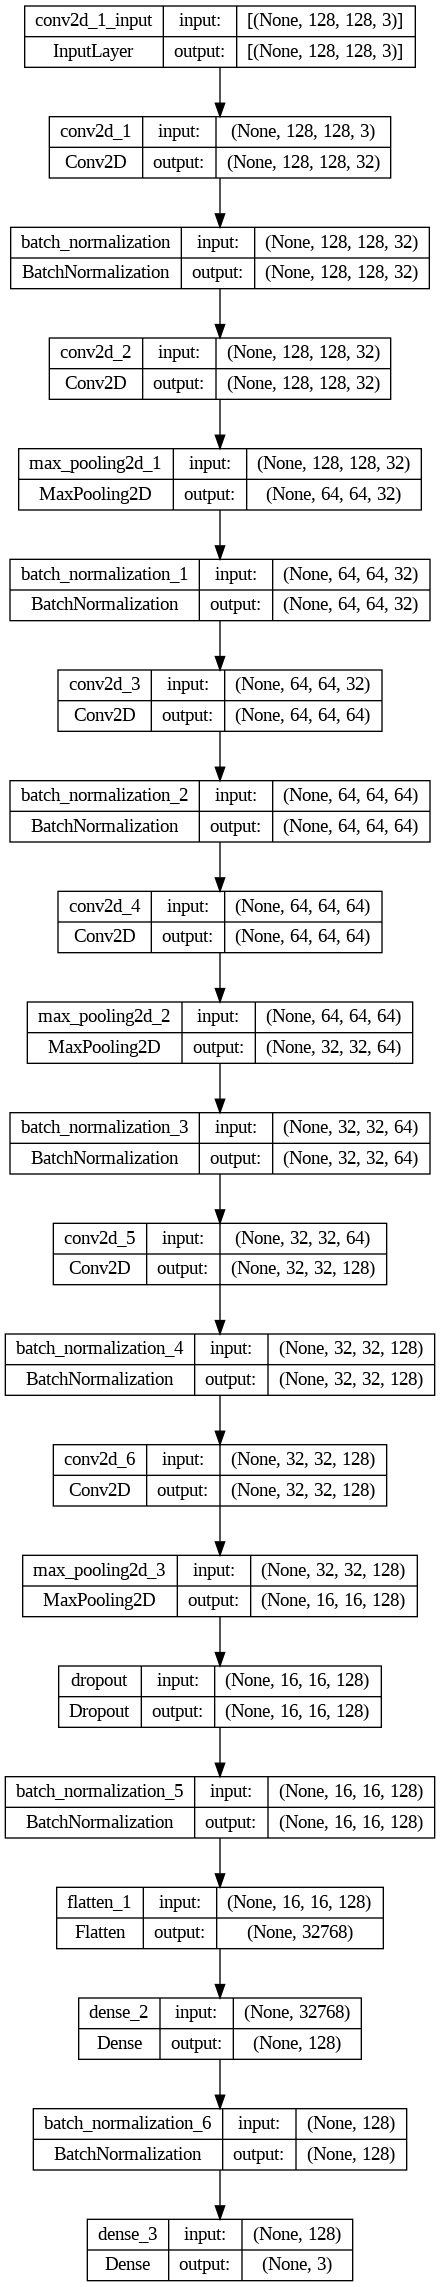

In [ ]:
from keras.utils import plot_model

# Complete model architecture visualising layers and shapes

# draw the plot using seaborn
plot_model(complete_model, show_shapes=True, show_layer_names=True)

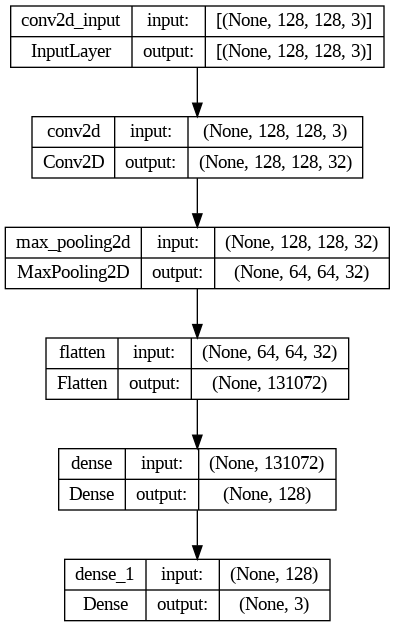

In [ ]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [ ]:
type(complete_model)

keras.engine.sequential.Sequential

In [ ]:
xception_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 model_5 (Functional)        (None, 4, 4, 3)           20867627  
                                                                 
 dense_7 (Dense)             (None, 4, 4, 3)           12        
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_11 (Dense)            (None, 1024)              50176     
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 3)                 1539

In [ ]:
complete_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 16.4 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-phd79xj_
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-phd79xj_
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [ ]:
import visualkeras

In [ ]:
# Visualisig our base model

visualkeras.layered_view(base_model, legend=True)

NameError: ignored

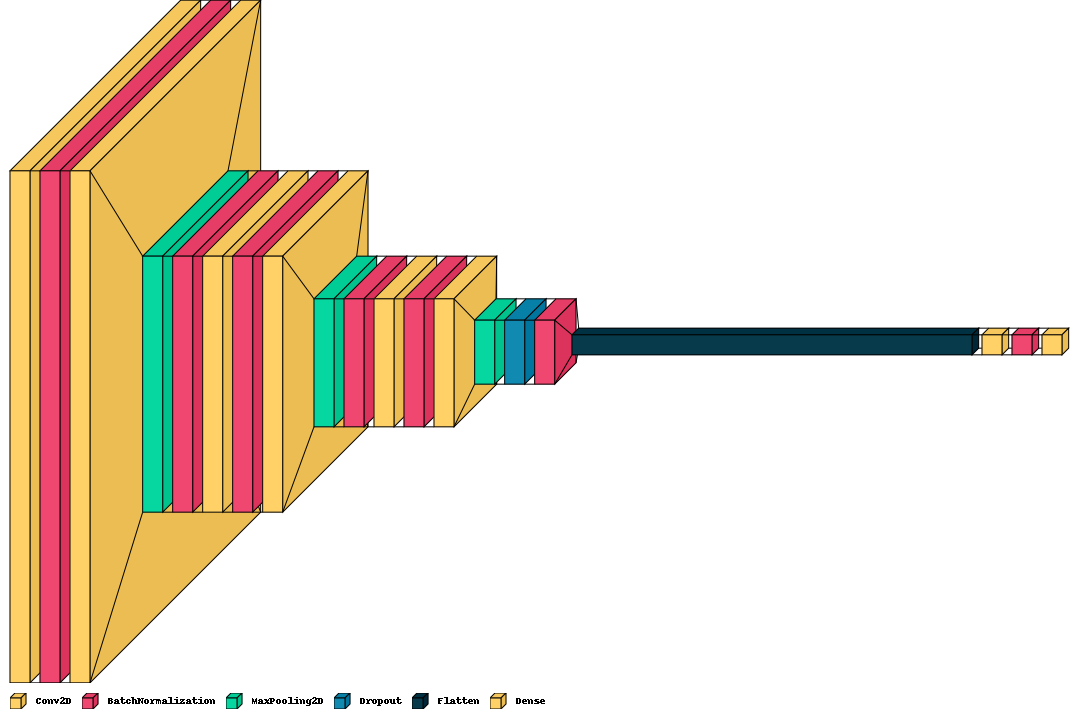

In [ ]:
visualkeras.layered_view(complete_model, legend=True)

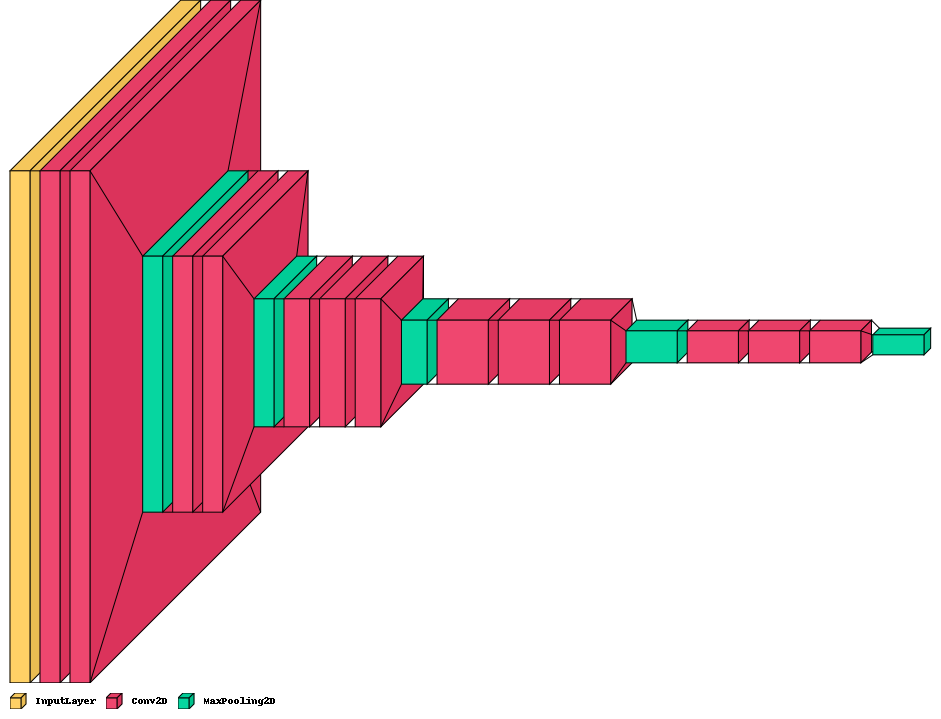

In [ ]:
visualkeras.layered_view(vgg_import, legend=True)